# Analysis of probe

In [4]:
import numpy as np
import json
from matplotlib import pyplot as plt
from tqdm import tqdm

## Run Conditions

In [6]:
GunXPosition = np.empty((80, 1))
GunYPosition = np.empty((80, 1))
GunZPosition = np.empty((80, 1))
PE = np.empty((80, 2, 1000))

for run_number in tqdm(range(80)):
    with open(f"./run{run_number}/RunConditions.json", "r") as run_conditions_json:
        run_condition_loaded = json.load(run_conditions_json)
        GunXPosition[run_number] = run_condition_loaded["GunXPosition/cm"]
        GunYPosition[run_number] = run_condition_loaded["GunYPosition/cm"]
        GunZPosition[run_number] = run_condition_loaded["GunZPosition/cm"]
    
    for SiPMNb in range(2):
        with open(f"./run{run_number}/PEs of SiPM/SiPM_{SiPMNb}.csv", "r") as PEFile:
            PE[run_number][SiPMNb] = np.loadtxt(PEFile, comments='#', delimiter=',', dtype=np.int8, usecols=0)

100%|██████████| 80/80 [00:00<00:00, 243.14it/s]


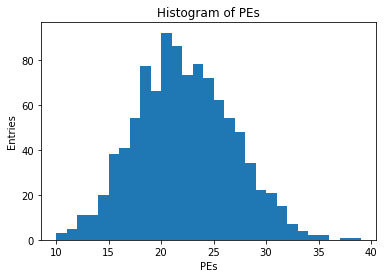

In [19]:
plt.hist(PE[0][0], bins=int(PE[0][0].max() - PE[0][0].min()))
plt.xlabel("PEs")
plt.ylabel("Entries")
plt.title("Histogram of PEs")
plt.show()

In [12]:
PEMean = PE.mean(axis=2)
PEStd = PE.std(axis=2)

PEMean_plot = np.empty(80, 80, 1)

[[ 21.703  97.435]
 [ 25.282  75.427]
 [ 28.444  64.844]
 [ 30.666  59.525]
 [ 32.405  54.905]
 [ 33.595  50.873]
 [ 35.349  48.367]
 [ 37.077  45.271]
 [ 38.967  43.307]
 [ 40.998  41.043]
 [ 43.219  38.566]
 [ 45.532  37.071]
 [ 48.012  35.674]
 [ 50.974  33.958]
 [ 54.781  32.612]
 [ 59.426  30.827]
 [ 65.272  28.556]
 [ 75.482  25.631]
 [ 97.427  21.931]
 [ 22.674  99.677]
 [ 26.633  77.374]
 [ 29.414  67.333]
 [ 31.849  61.716]
 [ 33.598  56.741]
 [ 34.961  53.015]
 [ 36.675  49.676]
 [ 38.889  47.045]
 [ 40.501  44.789]
 [ 42.923  42.378]
 [ 44.824  40.67 ]
 [ 46.852  38.521]
 [ 49.809  36.919]
 [ 53.117  34.912]
 [ 56.157  33.494]
 [ 61.724  32.017]
 [ 67.592  29.593]
 [ 77.798  26.257]
 [ 98.726  22.47 ]
 [ 23.539 100.683]
 [ 28.371  81.237]
 [ 31.439  71.163]
 [ 33.665  65.318]
 [ 35.452  60.021]
 [ 37.447  56.233]
 [ 38.904  52.742]
 [ 41.071  50.307]
 [ 42.708  47.218]
 [ 44.838  45.141]
 [ 47.599  42.862]
 [ 50.121  40.81 ]
 [ 52.898  38.493]
 [ 55.692  37.322]
 [ 60.331  3